# Tutorial Notebook for Differential Exon Usage with OmicSoft Data

This notebook demonstrates how to perform Differential Exon Usage (DEU) analysis using the OmicSoft DiseaseLand resource for schizophrenia vs. control samples 
in the Nucleus Accumbens (NAcc) brain tissue. The workflow integrates Python for data access and preprocessing, and R for DEXSeq splicing analysis.

### 1. Environment Setup

In [1]:
# Python library imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Connection to the OmicSoft API
from opi import *
datastore = OPI()

# Import R into the Notebook
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


### 2. Query the data from OmicSoft: schizophrenia studies with matched controls from the nucleus accumbens tissue and white ancestry

The DEXSeq analysis requires metadata, a count matrix (exons x samples) and annotations of the samples. We have to retreive the appropriate data from OmicSoft to fulfill these requirements.
We will use the following tables from OmicSoft Lands DiseaseLand from the 'human_disease_b38_gc33' data table depicted on the picture below.

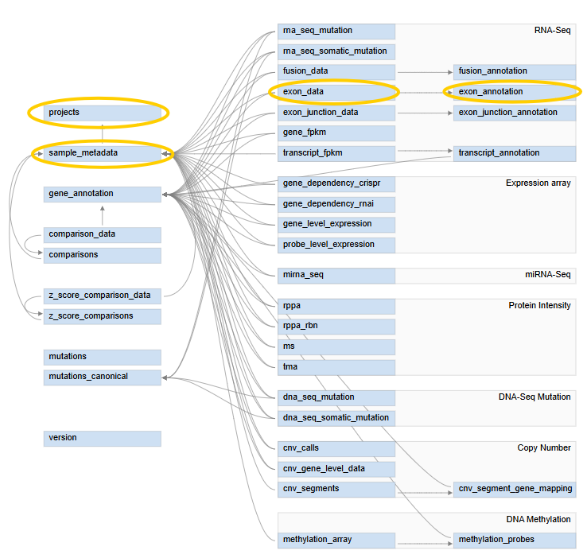

#### 1. Metadata extraction

In [2]:
# Find studies that contain schizophrenia and matching samples from the same studies
sql = """WITH schizophrenia_studies AS (
    SELECT DISTINCT s.project_id
    FROM human_disease_b38_gc33.samples s
    WHERE s.disease_state = 'schizophrenia'
      AND s.tissue = 'nucleus accumbens'
      AND s.ethnicity = 'White'
),

target_samples AS (
    SELECT s.sample_index, s.disease_state, s.tissue, s.ethnicity, s.age_summary, s.gender, s.project_id, p.title AS study_title
    FROM human_disease_b38_gc33.samples s
    JOIN human_disease_b38_gc33.projects p
      ON s.project_id = p.project_id
    WHERE s.tissue = 'nucleus accumbens'
      AND s.ethnicity = 'White'
      AND (
          s.disease_state = 'schizophrenia'
          OR (s.disease_state IN ('normal control', 'disease control')
              AND s.project_id IN (SELECT project_id FROM schizophrenia_studies))
      )
)

SELECT * 
FROM target_samples
"""
metadata = datastore.query(sql)
print(metadata.head())
print(f"Metadata shape: {metadata.shape}")

   sample_index    disease_state             tissue ethnicity age_summary  \
0        222724  disease control  nucleus accumbens     White    50 years   
1        222693  disease control  nucleus accumbens     White    36 years   
2        222681  disease control  nucleus accumbens     White    49 years   
3         85956   normal control  nucleus accumbens     White    67 years   
4         85827    schizophrenia  nucleus accumbens     White    63 years   

   gender project_id                                        study_title  
0    male  GSE202537  Diurnal alterations in gene expression across ...  
1  female  GSE202537  Diurnal alterations in gene expression across ...  
2    male  GSE202537  Diurnal alterations in gene expression across ...  
3    male   GSE80655  RNA-sequencing of human post-mortem brain tissues  
4    male   GSE80655  RNA-sequencing of human post-mortem brain tissues  
Metadata shape: (80, 8)


In [3]:
# Clean up the metadata
# rename age_summary to age that contains numeric values only
metadata['age'] = metadata['age_summary'].str.extract(r'(\d+)').astype(int)
# disease_state to simpler case/control
metadata['disease_state'] = metadata['disease_state'].replace({'disease control': 'normal control'})
# Sort sample_indexes
metadata = metadata.sort_values(by="sample_index")

# Final check of the metadata
print(metadata.head())
print(metadata.groupby(["disease_state", "ethnicity"])["age"].describe())   

    sample_index   disease_state             tissue ethnicity age_summary  \
53         85785   schizophrenia  nucleus accumbens     White    31 years   
69         85787  normal control  nucleus accumbens     White    45 years   
47         85788   schizophrenia  nucleus accumbens     White    53 years   
73         85815  normal control  nucleus accumbens     White    70 years   
33         85816  normal control  nucleus accumbens     White    35 years   

    gender project_id                                        study_title  age  
53  female   GSE80655  RNA-sequencing of human post-mortem brain tissues   31  
69    male   GSE80655  RNA-sequencing of human post-mortem brain tissues   45  
47  female   GSE80655  RNA-sequencing of human post-mortem brain tissues   53  
73    male   GSE80655  RNA-sequencing of human post-mortem brain tissues   70  
33    male   GSE80655  RNA-sequencing of human post-mortem brain tissues   35  
                          count       mean        std   m

#### 2. Count matrix preparation

In order to make a count matrix with shape (exons x samples), the 'exon_data' table needs to be queried and pivoted. To ensure the samples included here match the ones we queried from the metadata, we will query data with the same 'sample_index' values as in the metadata.

In [4]:
# Query exon data for the selected samples
sql = """WITH schizophrenia_studies AS (
    SELECT DISTINCT s.project_id
    FROM human_disease_b38_gc33.samples s
    WHERE s.disease_state = 'schizophrenia'
      AND s.tissue = 'nucleus accumbens'
      AND s.ethnicity = 'White'
),
target_samples AS (
    SELECT s.sample_index
    FROM human_disease_b38_gc33.samples s
    WHERE s.tissue = 'nucleus accumbens'
      AND s.ethnicity = 'White'
      AND (
          s.disease_state = 'schizophrenia'
          OR (s.disease_state IN ('normal control', 'disease control')
              AND s.project_id IN (SELECT project_id FROM schizophrenia_studies))
      )
)
SELECT 
    ed.sample_index,
    ed.exon_index,
    ed.read_count
FROM human_disease_b38_gc33.exon_data ed
JOIN target_samples ts
  ON ed.sample_index = ts.sample_index
"""
exon_data = datastore.query(sql)
print(exon_data.head())
print(f"Exon data shape: {exon_data.shape}")

   sample_index  exon_index  read_count
0         85896      385397         0.0
1         85896      385396         0.0
2         85896      385399         7.0
3         85896      385398         0.0
4         85920      385396         0.0
Exon data shape: (32241920, 3)


In [5]:
# Pivot table to make count matrix (exons x samples) from the queried long-format data
count_matrix = exon_data.pivot_table(index='exon_index',
                                           columns='sample_index',
                                           values='read_count', 
                                           fill_value=0)


count_matrix = count_matrix.sort_values(by="exon_index")
print(count_matrix.head())
print(f"Count matrix shape is: {count_matrix.shape}")
print("Row index (exon IDs) type:", count_matrix.index.dtype)
print("Column names (sample IDs) type:", count_matrix.columns.dtype)


sample_index  85785     85787     85788     85815     85816     85817   \
exon_index                                                               
0                1.0       1.0      0.74       1.0       1.3      0.92   
1              20.68   21.3498  18.64222      16.9      15.8  17.21556   
2              16.08  33.94348  16.77778     18.58     20.82  32.75003   
3              23.68  24.15652     23.54  24.15167  19.41837  24.72462   
4              27.64  25.75652     26.12  27.65167  28.69837  28.02462   

sample_index    85818     85827     85832     85833   ...    222727    222728  \
exon_index                                            ...                       
0                  0.0       0.0      0.26       0.0  ...  7.037838       0.0   
1             23.01188     22.94  12.65347  11.82829  ...  48.95189  109.8223   
2             29.51633     27.96     17.28  19.53171  ...  103.3423   131.424   
3             23.86512  21.32296     13.88      34.4  ...  68.04674  89.3231

#### 3. Querying matching exon annotations

In [6]:
sql ="""
WITH schizophrenia_studies AS (
    SELECT DISTINCT s.project_id
    FROM human_disease_b38_gc33.samples s
    WHERE s.disease_state = 'schizophrenia'
      AND s.tissue = 'nucleus accumbens'
      AND s.ethnicity = 'White'
),
target_samples AS (
    SELECT s.sample_index
    FROM human_disease_b38_gc33.samples s
    WHERE s.tissue = 'nucleus accumbens'
      AND s.ethnicity = 'White'
      AND (
          s.disease_state = 'schizophrenia'
          OR (s.disease_state IN ('normal control', 'disease control')
              AND s.project_id IN (SELECT project_id FROM schizophrenia_studies))
      )
)
SELECT 
    ea.exon_index,
    ea.exon_id,
    ea.chromosome,
    ea.start,
    ea."end" AS exon_end,
    ea.gene_id,
    ea.gene_name,
    ea.transcripts
FROM human_disease_b38_gc33.exon_annotation ea
WHERE ea.exon_index IN (
    SELECT DISTINCT ed.exon_index
    FROM human_disease_b38_gc33.exon_data ed
    JOIN target_samples ts
      ON ed.sample_index = ts.sample_index
)
"""

exon_annotation = datastore.query(sql)
exon_annotation = exon_annotation.sort_values(by="exon_index")
print(exon_annotation.head())
print(f"Exon annotation shape: {exon_annotation.shape}")

# Get rid of duplicate exon annotations if any
exon_annotation = exon_annotation.drop_duplicates(subset=['exon_index'])
print(f"Exon annotation shape after removing duplicates: {exon_annotation.shape}")

        exon_index                exon_id chromosome      start   exon_end  \
120822           0  1:100000637-100000739          1  100000637  100000739   
250907           1  1:100007034-100007156          1  100007034  100007156   
250906           1  1:100007034-100007156          1  100007034  100007156   
273262           2  1:100011365-100011533          1  100011365  100011533   
273261           2  1:100011365-100011533          1  100011365  100011533   

                   gene_id   gene_name  \
120822   ENSG00000202259.1  RNU6-1318P   
250907   ENSG00000283761.1  AC118553.2   
250906  ENSG00000117620.15     SLC35A3   
273262   ENSG00000283761.1  AC118553.2   
273261  ENSG00000117620.15     SLC35A3   

                                              transcripts  
120822                                  ENST00000365389.1  
250907                ENST00000638792.1;ENST00000639037.1  
250906  ENST00000638371.1;ENST00000427993.7;ENST000005...  
273262                ENST00000638792.

Save the resulting dataframes

In [9]:
Path("data").mkdir(exist_ok=True)

metadata.to_csv("data/metadata.csv", index=False)
count_matrix.to_csv("data/count_matrix.csv")
exon_annotation.to_csv("data/exon_annotation.csv", index=False)

### 3. Sanity checks and quality control

In [10]:
print(f"Metadata shape: {metadata.shape}")
print(f"Count matrix shape: {count_matrix.shape}")
print(f"Exon annotation shape: {exon_annotation.shape}")

# Metadata rows should match count matrix columns
assert metadata.shape[0] == count_matrix.shape[1], "Metadata and count matrix mismatch!"

# Exon annotation rows should match count matrix rows
assert count_matrix.shape[0] == exon_annotation.shape[0], "Exon counts and annotations mismatch!"

Metadata shape: (80, 9)
Count matrix shape: (396445, 80)
Exon annotation shape: (396445, 8)


In [11]:
# Print value counts for metadata columns
for col in ["tissue", "gender", "disease_state", "ethnicity"]:
    print(f"Value counts for '{col}':")
    print(metadata[col].value_counts())
    print()

# Descriptive statistics for age by disease state
metadata.groupby(["disease_state"])["age"].describe()


Value counts for 'tissue':
tissue
nucleus accumbens    80
Name: count, dtype: Int64

Value counts for 'gender':
gender
male      65
female    15
Name: count, dtype: Int64

Value counts for 'disease_state':
disease_state
normal control    48
schizophrenia     32
Name: count, dtype: Int64

Value counts for 'ethnicity':
ethnicity
White    80
Name: count, dtype: Int64



,count,mean,std,min,25%,50%,75%,max
disease_state,,,,,,,,
normal control,48.0,47.229167,11.255712,21.0,40.0,48.0,53.50,70.0
schizophrenia,32.0,44.812500,10.532400,24.0,36.0,44.5,52.25,63.0


In [12]:
# Distribution of total counts per exon
exon_counts = count_matrix.sum(axis=1)
print("Distribution of exon total counts:")
print(exon_counts.describe())

Distribution of exon total counts:
count         396445.0
mean      23485.485747
std      721345.764226
min                0.0
25%         177.255931
50%         1812.43165
75%         8325.54946
max      220827033.636
dtype: Float64


In [13]:
# Inspecting unique genes in the exon annotation
print(f"Number of unique gene IDs: {len(exon_annotation['gene_id'].unique())}")

Number of unique gene IDs: 60670


Distribution of exon total counts:
count         249197.0
mean      37268.025956
std      909556.428631
min         435.963581
25%        2212.475905
50%        5707.031817
75%       16128.487391
max      220827033.636
dtype: Float64


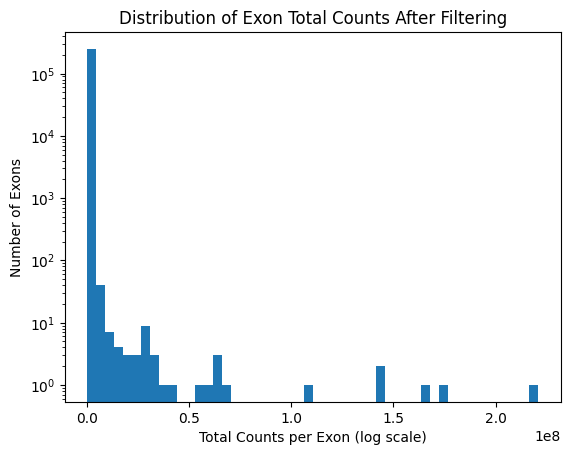

In [14]:
# Filter low coverage exons (can be adjusted according to need)
# Keep exons with at least 10 counts in at least 24 samples (30% of 80)
keep = (count_matrix >= 10).sum(axis=1) >= 24
filtered_count_matrix = count_matrix[keep]

# print distribution again + histogram
exon_counts = filtered_count_matrix.sum(axis=1)
print("Distribution of exon total counts:")
print(exon_counts.describe())

# Histogram of exon counts (log scale)
plt.hist(exon_counts, bins=50, log=True)
plt.xlabel('Total Counts per Exon (log scale)') 
plt.ylabel('Number of Exons')
plt.title('Distribution of Exon Total Counts After Filtering')
plt.show()

### 4. DEXSeq analysis in R

#### Prepare for analysis

In [2]:
# Import R into the Notebook
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.
c:\Users\biasz\AppData\Local\Programs\Python\Python311\Lib\site-packages\rpy2\ipython\rmagic.py:90: UserWarning: The Python package `pandas` is strongly recommended when using `rpy2.ipython`. Unfortunately it could not be loaded (error: No module named 'pandas'), but at least we found `numpy`.
  warnings.warn('The Python package `pandas` is strongly '


In [6]:
%%R
# Load necessary R libraries
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install(c("DEXSeq", "BiocParallel", "SummarizedExperiment"), ask = FALSE)

library(DEXSeq)
library(vroom)
library(GenomicRanges)

# Set up parallel processing for heavier computations
bp <- BiocParallel::SnowParam(4, type = "SOCK")

# Import data (if needed)
metadata <- vroom("data/metadata.csv", col_names = TRUE)
count_matrix <- vroom("data/count_matrix.csv", col_names = TRUE)
exon_data <- vroom("data/exon_annotation.csv", col_names = TRUE)

# View head of data
head(metadata)
head(count_matrix)
head(exon_data)


  There is a binary version available but the source version is later:
          binary source needs_compilation
Rsamtools 2.24.0 2.24.1              TRUE

  Binaries will be installed
package 'Rsamtools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\biasz\AppData\Local\Temp\RtmpEZVUXW\downloaded_packages
Rows: 80 Columns: 9
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (7): disease_state, tissue, ethnicity, age_summary, gender, project_id, ...
dbl (2): sample_index, age

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 396445 Columns: 80
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (80): 85785, 85787, 85788, 85815, 85816, 85817, 85818, 85827, 85832, 858...

i Use `spec()` to retrieve the full column specification for this 

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13 ucrt)
Installing package(s) 'BiocParallel'
Installation paths not writeable, unable to update packages
  path: C:/Program Files/R/R-4.5.1/library
  packages:
    boot, Matrix
Old packages: 'BiocParallel', 'DESeq2', 'Rsamtools'
trying URL 'https://bioconductor.org/packages/3.21/bioc/bin/windows/contrib/4.5/Rsamtools_2.24.0.zip'
Content type 'application/zip' length 8874976 bytes (8.5 MB)
downloaded 8.5 MB

In addition: Warning messages:
1: package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DEXSeq' 'SummarizedExperiment' 
2: In file.copy(savedcopy, lib, recursive = TRUE) :
  problem copying C:\Users\biasz\AppData\Local\R\win-library\4.5\00LOCK\Rsamtools\libs\x64\Rsamtools.dll to C:\Users\biasz\AppData\Local\R\win-library\4.5\Rsamtools\libs\x64\Rsamtools.dll: Permission denied


In [15]:
%%R
## ---- Preparations for DEXSeq : metadata, count matrix, exon annotation ----

## Count matrix ##
# Save exon IDs before dropping the column
exon_ids <- exon_data$exon_index
cat("Exon IDs are:", head(exon_ids), "\n")

# Set count matrix as matrix excluding the first column
count_matrix <- as.matrix(count_matrix)

# Assign exon IDs as rownames (because we need them to match the exon data)
rownames(count_matrix) <- exon_ids
cat("Count matrix with exon IDs as rownames: \n", head(rownames(count_matrix)), "\n")

# Convert matrix into integers before applying to DEXSeq analysis
mode(count_matrix) <- "integer"

# Sanity check the structure of the count matrix
cat("Count matrix structure: \n", head(count_matrix), "\n")
cat("Count matrix dimensions: ", dim(count_matrix), "\n")
## Metadata ##
# Convert all character columns to factors
metadata$title <- make.names(metadata$study_title)
metadata$disease_state <- make.names(metadata$disease_state)

char_cols <- sapply(metadata, is.character)
if (any(char_cols)) {
  message("Converting character columns to factors: ", paste(names(metadata)[char_cols], collapse = ", "))
  metadata[char_cols] <- lapply(metadata[char_cols], as.factor)
}
# Set 'normal.control' as the reference level for disease_state
metadata$disease_state = relevel(metadata$disease_state, ref = "normal.control")

# Ensure sample_index is character and used as rownames
metadata <- as.data.frame(metadata)  # <- converts tibble to data.frame
metadata$sample_index <- as.character(metadata$sample_index)
rownames(metadata) <- metadata$sample_index

## Exon annotation ##
# Create a GRanges object from exon annotation
exon_ranges <- GRanges(
  seqnames = exon_data$chromosome,
  ranges = IRanges(start = exon_data$start, end = exon_data$exon_end),
  strand = "*",  # strand information is unavailable
  featureID = as.character(exon_data$exon_index),
  groupID = exon_data$gene_name,
  seqinfo = Seqinfo(seqnames = unique(exon_data$chromosome), genome = "GRCh38")
)

# Match to filtered count matrix rows
exon_ranges <- exon_ranges[match(rownames(count_matrix), exon_data$exon_index)]

# Sanity check the exon_ranges
cat("Exon ranges (first few):\n")
print(head(exon_ranges))


Exon IDs are: 0 1 2 3 4 5 


Count matrix with exon IDs as rownames: 
 0 1 2 3 4 5 
Count matrix structure: 
 1 20 16 23 27 27 1 21 33 24 25 21 0 18 16 23 26 25 1 16 18 24 27 24 1 15 20 19 28 38 0 17 32 24 28 29 0 23 29 23 26 26 0 22 27 21 23 29 0 12 17 13 13 24 0 11 19 34 36 22 0 22 27 26 26 24 0 10 6 12 12 9 0 20 26 23 24 22 2 10 12 11 13 9 0 6 7 14 14 10 0 45 48 48 53 45 2 43 57 63 70 39 0 27 22 31 45 32 0 38 61 53 57 61 0 24 30 40 43 21 0 53 47 71 78 70 0 27 37 50 55 36 1 30 40 37 39 39 2 35 52 44 48 35 3 39 30 44 49 44 1 33 57 69 73 54 0 41 61 70 72 67 0 59 85 88 94 72 1 5 14 12 12 15 0 22 26 33 36 34 1 51 61 61 65 55 0 34 36 45 46 47 0 33 39 52 54 44 3 26 15 23 33 24 1 29 35 36 38 41 0 18 15 30 41 23 1 8 14 14 20 13 1 1 13 12 18 13 1 44 38 67 75 80 1 75 86 59 75 39 2 71 130 66 83 56 1 82 149 78 96 77 4 73 134 66 84 63 2 61 112 64 73 50 3 93 122 71 103 64 2 53 72 47 64 43 2 70 95 68 84 46 0 88 148 94 103 58 0 70 97 76 88 57 4 41 73 61 71 33 2 100 184 123 148 66 1 82 162 85 105 56 0 45 80 47 64 36 0 67 107 62

Converting character columns to factors: sample_index, disease_state, title


#### Build DEXSeq Dataset

In [ ]:
%%R
# Build DEXSeqDataSet
dxd <- DEXSeqDataSet(
  countData = count_matrix, 
  sampleData = metadata,
  design = ~ sample_index + exon + title:exon + disease_state:exon, # accounts for study-related batch effects
  # Design formula if ran on individual studies:
  #design = ~ sample_index + exon + disease_state:exon,
  featureID = rownames(count_matrix),
  groupID = exon_data$gene_id,
  featureRanges = exon_ranges,
  transcripts = exon_data$transcripts 
)
head(dxd)

class: DEXSeqDataSet 
dim: 6 160 
metadata(1): version
assays(1): counts
rownames(6): ENSG00000202259.1:0 ENSG00000117620.15:1 ...
  ENSG00000117620.15:4 ENSG00000117620.15:5
rowData names(5): featureID groupID exonBaseMean exonBaseVar
  transcripts
colnames: NULL
colData names(12): sample sample_index ... title exon


converting counts to integer mode
In addition: Warning message:
In DESeqDataSet(rse, design, ignoreRank = TRUE) :
  some variables in design formula are characters, converting to factors


In [16]:
%%R
## ---- Sanity checks for DEXSeqDataSet (dxd) ----

cat("\n──────────────────────────────\n")
cat("1️⃣  Sample-level metadata (colData)\n")
cat("──────────────────────────────\n")
print(head(as.data.frame(colData(dxd)), 5))   # show first 5 samples

cat("\n──────────────────────────────\n")
cat("2️⃣  Exon-level count matrix (counts)\n")
cat("──────────────────────────────\n")
print(head(counts(dxd), 5))   # show first 5 exons

cat("\n──────────────────────────────\n")
cat("3️⃣  Feature-level counts (featureCounts)\n")
cat("──────────────────────────────\n")
print(head(featureCounts(dxd), 5))

cat("\n──────────────────────────────\n")
cat("4️⃣  Exon genomic coordinates (rowRanges)\n")
cat("──────────────────────────────\n")
print(head(as.data.frame(rowRanges(dxd)), 3))   # 3 rows for clarity

cat("\n──────────────────────────────\n")
cat("5️⃣  Sample annotation\n")
cat("──────────────────────────────\n")
print(head(as.data.frame(sampleAnnotation(dxd)), 5))



------------------------------
1<U+FE0F><U+20E3>  Sample-level metadata (colData)
------------------------------
  sample sample_index  disease_state            tissue ethnicity age_summary
1  85785        85785  schizophrenia nucleus accumbens     White    31 years
2  85787        85787 normal.control nucleus accumbens     White    45 years
3  85788        85788  schizophrenia nucleus accumbens     White    53 years
4  85815        85815 normal.control nucleus accumbens     White    70 years
5  85816        85816 normal.control nucleus accumbens     White    35 years
  gender project_id                                       study_title age
1 female   GSE80655 RNA-sequencing of human post-mortem brain tissues  31
2   male   GSE80655 RNA-sequencing of human post-mortem brain tissues  45
3 female   GSE80655 RNA-sequencing of human post-mortem brain tissues  53
4   male   GSE80655 RNA-sequencing of human post-mortem brain tissues  70
5   male   GSE80655 RNA-sequencing of human post-morte

#### Run Differential Exon Usage Analysis

In [ ]:
%%R
# Estimate size factors, dispersions, and test
# Normalization
dxd = estimateSizeFactors(dxd)
dxd = estimateDispersions(dxd)

# DEU test
dxd = testForDEU(dxd, 
        reducedModel = ~ sample_index + exon + title:exon,
        # Design formula if ran on individual studies:
        #reducedModel = ~ sample_index + exon, # seperate studies
        BPPARAM = bp)

dxd <- estimateExonFoldChanges(dxd, fitExpToVar = "disease_state")

dxr = DEXSeqResults(dxd)

#### Visualizations

In [ ]:
%%R

# Dispersion plot
plotDispEsts(dxd)

# MA-plot
plotMA(dxr, main="MA-plot for differential exon usage", cex=0.8, cex.axis=1.2, cex.lab=1.2)

# Adjusted p-value histogram
hist(dxr$padj, breaks=100, main="Adjusted p-value histogram, all exons", xlab="Adjusted p-value")

# HTML report with all results (at FDR 0.05, change as needed)
DEXSeqHTML(dxr, FDR=0.05, fitExpToVar = "disease_state", color=c("skyblue", "pink"),  path = "DEXSeqReport/dexseq_html_report")

#### Reproducibility

In [18]:
%%R
#Session Info for Reproducibility
print(sessionInfo())

# DEXSeq version
print(packageVersion("DEXSeq"))

R version 4.5.1 (2025-06-13 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows 11 x64 (build 26100)

Matrix products: default
  LAPACK version 3.12.1

locale:
[1] LC_COLLATE=English_Denmark.1252  LC_CTYPE=English_Denmark.1252   
[3] LC_MONETARY=English_Denmark.1252 LC_NUMERIC=C                    
[5] LC_TIME=English_Denmark.1252    

time zone: Europe/Copenhagen
tzcode source: internal

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] vroom_1.6.6                 DEXSeq_1.54.1              
 [3] RColorBrewer_1.1-3          AnnotationDbi_1.70.0       
 [5] DESeq2_1.48.1               SummarizedExperiment_1.38.1
 [7] GenomicRanges_1.60.0        GenomeInfoDb_1.44.3        
 [9] IRanges_2.42.0              S4Vectors_0.46.0           
[11] MatrixGenerics_1.20.0       matrixStats_1.5.0          
[13] Biobase_2.68.0              BiocGenerics_0.54.0        
[15] generics_0.1.4    